# Variant regulatory consequence analysis

This notebook introduces new dataset `Epiraction`, which contains the regulatory consequences for variants.


## Data loading

The data requires two datasets:

- `Epiraction` dataset, which contains the regulatory consequences for variants.
- `LeadVariantEffect` dataset, which contains the lead variants and their effects.


In [12]:
from __future__ import annotations

from enum import Enum

import pandas as pd
import plotnine as p9
from gentropy.common.session import Session
from pyspark.sql import Column, Window
from pyspark.sql import functions as f

from manuscript_methods import OpenTargetsTheme, calculate_protein_altering_proportion, group_statistics
from manuscript_methods.datasets import LeadVariantEffect


In [ ]:
session = Session(extended_spark_conf={"spark.driver.memory": "120G"})
dataset_path = "../../data/epiraction_v1.6"

lead_variant_maf = "../../data/lead-maf-vep"
so_terms_path = "../../data/so_terms.tsv"
pd.set_option("display.max_colwidth", None)


In [3]:
session.spark


In [4]:
epirack = session.spark.read.parquet(dataset_path)
lve = LeadVariantEffect.from_parquet(session=session, path=lead_variant_maf)
so_terms = pd.read_csv(so_terms_path, sep="\t")


## Consequence classification

We classify the consequences into 4 categories:

- intergenic (upstream, downstream, and intergenic regions)
- regulatory (LOW or MODIFIER impact, bound to regulatory regions)
- intragenic (LOW or MODIFIER impact, rest)
- protein_altering (HIGH and MODERATE impact)

We need to merge the so_terms dataset, so the featureId contains the `SO_XXX` format rather then `SO:XXX` format.


In [24]:
# Change SO terms to the `SO_XXX` format
so_terms["featureId"] = so_terms["featureId"].str.replace("SO:", "SO_")


In [25]:
so_terms


,featureId,term,description,displayTerm,featureTerm,impact,rank,score
0,SO_0001893,transcript_ablation,A feature ablation whereby the deleted region includes a transcript feature,NaN,mRNA,HIGH,1,0.98
1,SO_0001574,splice_acceptor_variant,A splice variant that changes the 2 base region at the 3' end of an intron,ESSENTIAL_SPLICE_SITE,primary_transcript,HIGH,2,0.95
2,SO_0001575,splice_donor_variant,A splice variant that changes the 2 base region at the 5' end of an intron,ESSENTIAL_SPLICE_SITE,primary_transcript,HIGH,3,0.93
3,SO_0001587,stop_gained,"A sequence variant whereby at least one base of a codon is changed, resulting in a premature stop codon, leading to a shortened transcript",STOP_GAINED,mRNA,HIGH,4,0.90
4,SO_0001589,frameshift_variant,"A sequence variant which causes a disruption of the translational reading frame, because the number of nucleotides inserted or deleted is not a multiple of three",FRAMESHIFT_CODING,mRNA,HIGH,5,0.88
5,SO_0001578,stop_lost,"A sequence variant where at least one base of the terminator codon (stop) is changed, resulting in an elongated transcript",STOP_LOST,mRNA,HIGH,6,0.85
6,SO_0002012,start_lost,A codon variant that changes at least one base of the canonical start codon,NON_SYNONYMOUS_CODING,mRNA,HIGH,7,0.83
7,SO_0001889,transcript_amplification,A feature amplification of a region containing a transcript,NaN,mRNA,HIGH,8,0.80
8,SO_0001907,feature_elongation,"A sequence variant that causes the extension of a genomic feature, with regard to the reference sequence",NaN,sequence_feature,HIGH,9,0.78
9,SO_0001906,feature_truncation,"A sequence variant that causes the reduction of a genomic feature, with regard to the reference sequence",NaN,sequence_feature,HIGH,10,0.76


In [48]:
class IntergenicConsequence(str, Enum):
    """Enum for intergenic consequences."""

    UPSTREAM = "upstream_gene_variant"
    DOWNSTREAM = "downstream_gene_variant"
    INTERGENIC = "intergenic_variant"


class RegulatoryConsequence(str, Enum):
    """Enum for regulatory consequences."""

    TFBS_ABLATION = "TFBS_ablation"
    TFBS_AMPLIFICATION = "TFBS_amplification"
    TF_BINDING_SITE_VARIANT = "TF_binding_site_variant"
    REGULATORY_REGION_ABLATION = "regulatory_region_ablation"
    REGULATORY_REGION_AMPLIFICATION = "regulatory_region_amplification"
    REGULATORY_REGION_VARIANT = "regulatory_region_variant"


class IntragenicConsequence(str, Enum):
    """Enum for intragenic consequences."""

    SPLICE_DONOR_5TH_BASE_VARIANT = "splice_donor_5th_base_variant"
    SPLICE_REGION_VARIANT = "splice_region_variant"
    SPLICE_DONOR_REGION_VARIANT = "splice_donor_region_variant"
    SPLICE_POLYPYRIMIDINE_TRACT_VARIANT = "splice_polypyrimidine_tract_variant"
    INCOMPLETE_TERMINAL_CODON_VARIANT = "incomplete_terminal_codon_variant"
    START_RETAINED_VARIANT = "start_retained_variant"
    STOP_RETAINED_VARIANT = "stop_retained_variant"
    SYNONYMOUS_VARIANT = "synonymous_variant"
    CODING_SEQUENCE_VARIANT = "coding_sequence_variant"
    MATURE_MIRNA_VARIANT = "mature_miRNA_variant"
    FIVE_PRIME_UTR_VARIANT = "5_prime_UTR_variant"
    THREE_PRIME_UTR_VARIANT = "3_prime_UTR_variant"
    NON_CODING_TRANSCRIPT_EXON_VARIANT = "non_coding_transcript_exon_variant"
    INTRON_VARIANT = "intron_variant"
    NMD_TRANSCRIPT_VARIANT = "NMD_transcript_variant"
    NON_CODING_TRANSCRIPT_VARIANT = "non_coding_transcript_variant"
    CODING_TRANSCRIPT_VARIANT = "coding_transcript_variant"


class ProteinAlteringConsequence(str, Enum):
    """Enum for protein-altering consequences."""

    TRANSCRIPT_ABLATION = "transcript_ablation"
    SPLICE_ACCEPTOR_VARIANT = "splice_acceptor_variant"
    SPLICE_DONOR_VARIANT = "splice_donor_variant"
    STOP_GAINED = "stop_gained"
    FRAMESHIFT_VARIANT = "frameshift_variant"
    STOP_LOST = "stop_lost"
    START_LOST = "start_lost"
    TRANSCRIPT_AMPLIFICATION = "transcript_amplification"
    FEATURE_ELONGATION = "feature_elongation"
    FEATURE_TRUNCATION = "feature_truncation"
    INFRAME_INSERTION = "inframe_insertion"
    INFRAME_DELETION = "inframe_deletion"
    MISSENSE_VARIANT = "missense_variant"
    PROTEIN_ALTERING_VARIANT = "protein_altering_variant"


class ConsequenceCategory(str, Enum):
    """Enum for consequence categories."""

    INTERGENIC = "intergenic"
    REGULATORY = "regulatory"
    INTRAGENIC = "intragenic"
    PROTEIN_ALTERING = "protein_altering"

    @classmethod
    def classify_so_terms(cls, so_terms: Column) -> Column:
        """Classify SO terms into consequence categories."""
        return (
            f.when(so_terms.isin(*IntergenicConsequence.__members__.values()), f.lit(cls.INTERGENIC.value))
            .when(so_terms.isin(*RegulatoryConsequence.__members__.values()), f.lit(cls.REGULATORY.value))
            .when(so_terms.isin(*IntragenicConsequence.__members__.values()), f.lit(cls.INTRAGENIC.value))
            .when(so_terms.isin(*ProteinAlteringConsequence.__members__.values()), f.lit(cls.PROTEIN_ALTERING.value))
            .otherwise(None)
        )


## Merging of LVE x Epiraction datasets

In order to add the regulatory consequences from the Epiraction we need to merge the `LeadVariantEffect` dataset with the Epiraction dataset. The Epiraction dataset contains the regulatory consequences for interval regions.

The Epiraction interval region is defined as
| chromosome | start | end | intervalType |
|------------|---------|---------|----------------|
| chr1 | 128717 | 129517 | promoter |
| chr1 | 138675 | 139325 | enhancer |
| chr1 | 96475 | 96925 | enhancer |
| chr1 | 103950 | 104600 | enhancer |

Where the `intervalType` can be `promoter` or `enhancer`

<div class="alert alert-block alert-info"> 
<b> Epiraction interval offset </b>
<br>
    Epiraction intervals are 0-based (based on bed intervals), while the `LeadVariantEffect` dataset is 1-based. This means that we need to add 1 to the start and end positions of the Epiraction intervals when merging with the 
    `LeadVariantEffect` dataset.
<br>
<br>
<img src="plots/0_vs_1_based.png" width="500"/>
</div>

The join to the `LeadVariantEffect` dataset is done using the positions to the lead variant.


### Extract the relevant information from both datasets


In [34]:
def map_so_terms(so_term_col: Column, so_terms: pd.DataFrame) -> Column:
    """Map Sequence Ontology (SO) terms to their ids without joining."""
    expr = f.when(f.lit(False), None)
    so_terms = so_terms[["featureId", "term"]]
    for v in so_terms.iterrows():
        so_term = v[1][1]
        so_id = v[1][0]
        expr = expr.when(f.lit(so_id) == so_term_col, f.lit(so_term))

    return expr


In [253]:
# Prefilter lead variants
lve_dataset = (
    lve.maf_filter()
    .effect_size_filter()
    .df.select(
        f.col("variantId"),
        f.col("variant.chromosome").alias("chromosome"),
        f.col("variant.start").alias("start"),
        f.col("variant.end").alias("end"),
        f.col("leadVariantConsequence").getField("type").alias("variantPositionEffect"),
        f.col("leadVariantConsequence")
        .getField("transcriptConsequence")
        .getField("consequenceScore")
        .alias("consequenceScore"),
        f.col("leadVariantConsequence")
        .getField("transcriptConsequence")
        .getField("variantFunctionalConsequenceIds")
        .alias("consequenceIds"),
        f.col("studyStatistics").getField("studyType").alias("studyType"),
        f.col("majorLdPopulationMaf").getField("value").alias("MAF"),
        f.col("rescaledStatistics").getField("estimatedBeta").alias("estimatedBeta"),
        f.col("rescaledStatistics").getField("estimatedSE").alias("estimatedSE"),
        f.col("studyStatistics").getField("traitClass").alias("traitClass"),
    )
    .withColumn("consequenceOntologyTerms", f.transform(f.col("consequenceIds"), lambda x: map_so_terms(x, so_terms)))
)
# Filter based on score distribution - see 05.0 notebook
epirack_dataset = (
    epirack.filter(f.col("score") > 0.05)
    .dropDuplicates(["chromosome", "start", "end", "intervalType"])
    .select(
        f.regexp_replace(f.col("chromosome"), "chr", "").alias("chromosome"),
        (f.col("start") + 1).alias("start"),
        (f.col("end") + 1).alias("end"),
        "intervalType",
    )
)


/var/folders/l7/4z91w2tj4wscfcpfjjy3s0mr0000gq/T/ipykernel_59315/2657062128.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [251]:
epirack_dataset.show()
epirack_dataset.count()


+----------+------------+------------+------------+
|chromosome|       start|         end|intervalType|
+----------+------------+------------+------------+
|         1|   1305301.0|   1305876.0|    enhancer|
|         1|   1712001.0|   1712451.0|    enhancer|
|         1|   2561876.0|   2562326.0|    enhancer|
|         1| 1.0796147E7| 1.0796947E7|    promoter|
|         1| 1.0965551E7| 1.0966251E7|    enhancer|
|         1| 4.0050801E7| 4.0051401E7|    enhancer|
|         1| 5.4546901E7| 5.4547351E7|    enhancer|
|         1| 7.5785957E7| 7.5786757E7|    promoter|
|         1| 8.4460001E7| 8.4460601E7|    enhancer|
|         1| 9.1511376E7| 9.1511826E7|    enhancer|
|         1|1.09091776E8|1.09092226E8|    enhancer|
|         1|1.11200147E8|1.11200947E8|    promoter|
|         1|1.45979826E8|1.45980526E8|    enhancer|
|         1| 1.4599608E8| 1.4599688E8|    promoter|
|         1|1.46052028E8|1.46052828E8|    promoter|
|         1|2.07248776E8|2.07249251E8|    enhancer|
|         1|

310359

In [252]:
lve_dataset.show()
lve_dataset.count()


+------------------+----------+---------+---------+---------------------+----------------+--------------------+---------+-------------------+--------------------+--------------------+--------------------------+------------------------+
|         variantId|chromosome|    start|      end|variantPositionEffect|consequenceScore|      consequenceIds|studyType|                MAF|       estimatedBeta|         estimatedSE|studyStatistics.traitClass|consequenceOntologyTerms|
+------------------+----------+---------+---------+---------------------+----------------+--------------------+---------+-------------------+--------------------+--------------------+--------------------------+------------------------+
|   3_126294567_C_T|         3|126294567|126294567|       in-gene-effect|             0.1|[SO_0001627, SO_0...|     eqtl| 0.2309559537470209| -1.3094279085260658| 0.10192017681824937|              quantitative|    [intron_variant, ...|
|   4_141222098_A_G|         4|141222098|141222098|     

2720012

### Save the datasets as tables partitioned by chromosome and sorted by position


In [254]:
lve_dataset.write.mode("overwrite").bucketBy(50, "chromosome").sortBy("start").saveAsTable("lve_lead_variants")
epirack_dataset.write.mode("overwrite").bucketBy(50, "chromosome").sortBy("start").saveAsTable("epirack_intervals")


### Perform the join between the LeadVariantEffect and Epiraction datasets

The join is left on lead_variant, so we keep all the lead variants and add the Epiraction information where available.

The Epiraction intervals are added when the lead variant is within the Epiraction interval.


In [255]:
lve_dataset_table = session.spark.table("lve_lead_variants")
epirack_dataset_table = session.spark.table("epirack_intervals")

nc_dataset = lve_dataset_table.join(
    epirack_dataset_table,
    on=(
        (lve_dataset_table.chromosome == epirack_dataset_table.chromosome)
        & (lve_dataset_table.start >= epirack_dataset_table.start)
        & (lve_dataset_table.end < epirack_dataset_table.end)
    ),
    how="left",
).select(
    lve_dataset_table.variantId,
    lve_dataset_table.chromosome,
    lve_dataset_table.start,
    lve_dataset_table.end,
    lve_dataset_table.variantPositionEffect,
    lve_dataset_table.consequenceScore,
    lve_dataset_table.consequenceOntologyTerms,
    lve_dataset_table.studyType,
    lve_dataset_table.MAF,
    lve_dataset_table.estimatedBeta,
    lve_dataset_table.estimatedSE,
    lve_dataset_table.traitClass,
    epirack_dataset_table.intervalType,
)


### Save the dataset after joining


In [256]:
nc_dataset.write.mode("overwrite").parquet("../../data/nc_dataset")


## Unify the consequence terms with Epiraction interval types

Before unification, we need to ensure that all the filtering is applied. We need two datasets:

1. **Mean estimated effect size in consequence categories** (gwas_dataset). The analysis is done on

   - the common variants (MAF >= 0.01)
   - with absolute value of estimated effect size <= 3
   - GWAS replicated credible sets (studyType == "gwas")
   - traitClass == "binary"

2. **Consequence categories fraction of all consequences across study types** (merged_dataset). The analysis is done on

   - the common variants (MAF >= 0.01)
   - with absolute value of estimated effect size <= 3
   - replicated credible sets (studyType == "gwas", "eqtl", "cis-pqtl")

After applying the specific filtering we need to unify the consequence terms with the Epiraction interval types. The unification is done by

- maping the consequence terms to consequence categories
- adding the Epiraction interval types to the consequence categories
- deduplicating the consequence terms
- removing the null entries (due to the left-join)
- exploding the unified non-duplicated list of terms.

At the end we remove the duplicates based on the variantId, consequence, and studyType.


In [260]:
# Extract only GWAS
gwas_dataset = (
    (
        nc_dataset.filter(f.col("studyType") == "gwas")
        .filter(f.col("MAF") >= 0.01)
        .filter(f.abs(f.col("estimatedBeta")) <= 3)
        .filter(f.col("traitClass") == "binary")
        .select(
            "variantId",
            "intervalType",
            "estimatedBeta",
            "estimatedSE",
            "studyType",
            "consequenceOntologyTerms",
            "MAF",
        )
    )
    .withColumn(
        "consequence",
        f.explode(
            f.filter(
                f.array_distinct(
                    f.array_sort(
                        f.array_append(
                            f.transform(
                                f.array_distinct(f.col("consequenceOntologyTerms")),
                                lambda x: ConsequenceCategory.classify_so_terms(x),
                            ),
                            f.col("intervalType"),
                        )
                    )
                ),
                lambda x: x.isNotNull(),
            )
        ),
    )
    .drop_duplicates(["variantId", "consequence", "studyType"])
    .cache()
)
gwas_dataset.count()


52747

In [261]:
# Extract merged dataset
merged_dataset = (
    (
        nc_dataset.filter(f.col("MAF") >= 0.01)
        .filter(f.col("studyType").isin(["gwas", "eqtl", "cis-pqtl"]))
        .filter(f.abs(f.col("estimatedBeta")) <= 3)
        .select(
            "variantId",
            "intervalType",
            "estimatedBeta",
            "estimatedSE",
            "studyType",
            "consequenceOntologyTerms",
            "MAF",
        )
    )
    .withColumn(
        "consequence",
        f.explode(
            f.filter(
                f.array_distinct(
                    f.array_sort(
                        f.array_append(
                            f.transform(
                                f.array_distinct(f.col("consequenceOntologyTerms")),
                                lambda x: ConsequenceCategory.classify_so_terms(x),
                            ),
                            f.col("intervalType"),
                        )
                    )
                ),
                lambda x: x.isNotNull(),
            )
        ),
    )
    .drop_duplicates(["variantId", "consequence", "studyType"])
    .cache()
)
merged_dataset.count()


922468

## Mean estimated effect size in consequence categories

The analysis is made to see the difference between the mean estimated effect size in different consequence categories within the GWAS replicated binary credible sets.


In [312]:
group_statistics(gwas_dataset, [f.col("consequence")]).show()


+----------------+-----+-----+------------------+
|     consequence|count|    %|        percentage|
+----------------+-----+-----+------------------+
|      intragenic|32993|62.55| 62.54952888315923|
|      intergenic|13544|25.68| 25.67728970367983|
|        enhancer| 4496| 8.52| 8.523707509431816|
|protein_altering|  920| 1.74|1.7441750241719907|
|        promoter|  794| 1.51|1.5052988795571312|
+----------------+-----+-----+------------------+



### Aggregate the estimated effect sizes

The aggregation is done by the consequence and studyType


In [313]:
beta = "\u03b2"
hat = "\u0302"
plus_minus = "\u00b1"


data = (
    gwas_dataset.groupBy("consequence", "studyType")
    .agg(
        f.mean(f.abs("estimatedBeta")).alias("meanAbsEstimatedBeta"),
        f.stddev(f.abs("estimatedBeta")).alias("stddevAbsEstimatedBeta"),
        f.count(f.col("variantId")).alias("variantCount"),
    )
    .withColumn(
        "label",
        f.concat_ws(
            " / ",
            "consequence",
            f.concat_ws("=", f.lit("N"), "variantCount"),
            f.concat_ws(
                plus_minus,
                f.concat_ws("=", f.lit(beta + hat), f.round("meanAbsEstimatedBeta", 3)),
                f.round("stddevAbsEstimatedBeta", 3),
            ),
        ),
    )
    .toPandas()
)
data


,consequence,studyType,meanAbsEstimatedBeta,stddevAbsEstimatedBeta,variantCount,label
0,enhancer,gwas,0.136164,0.252657,4496,enhancer / N=4496 / β̂=0.136±0.253
1,protein_altering,gwas,0.239358,0.384189,920,protein_altering / N=920 / β̂=0.239±0.384
2,intragenic,gwas,0.137023,0.256140,32993,intragenic / N=32993 / β̂=0.137±0.256
3,intergenic,gwas,0.150354,0.280243,13544,intergenic / N=13544 / β̂=0.15±0.28
4,promoter,gwas,0.125048,0.187450,794,promoter / N=794 / β̂=0.125±0.187


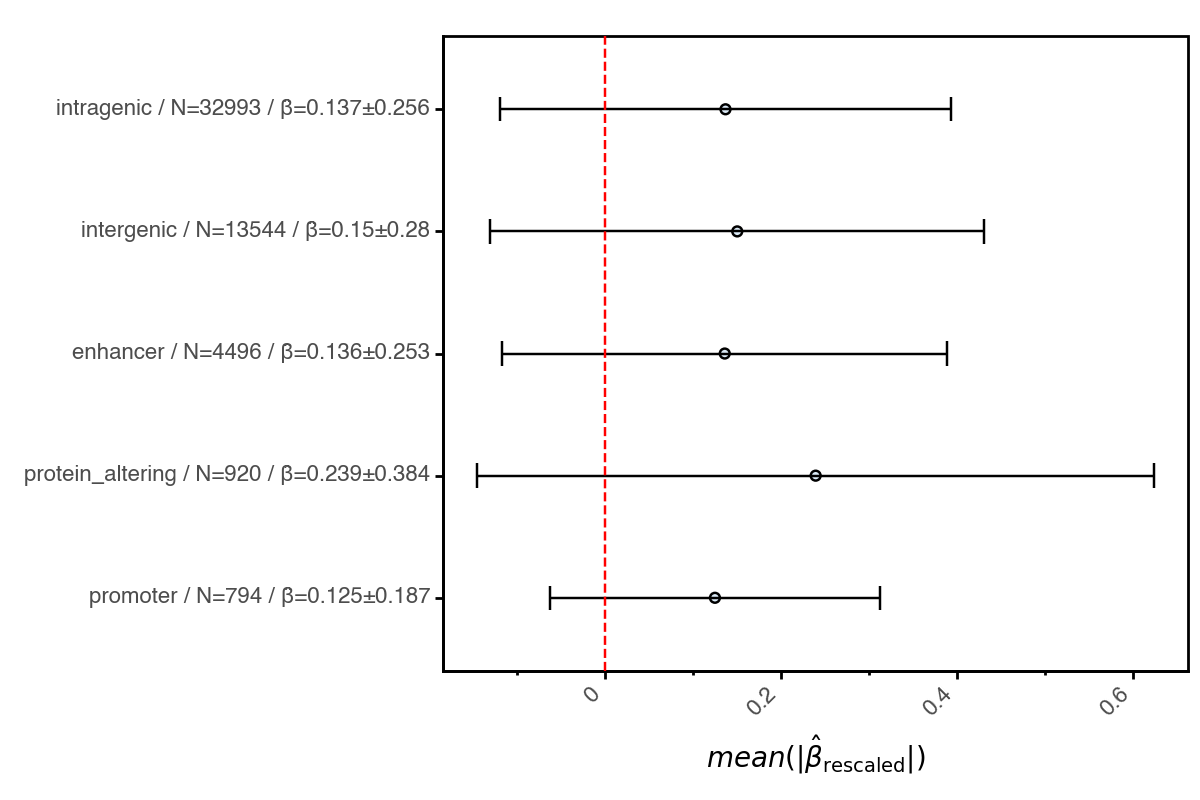

<Figure Size: (600 x 400)>

In [314]:
plot = (
    p9.ggplot(data)
    + p9.geom_point(p9.aes(x="reorder(label, variantCount)", y="meanAbsEstimatedBeta"), fill="#DBEAF6")
    + OpenTargetsTheme.theme
    + p9.theme(figure_size=(10, 6))
    # move the y-axis label to the bottom
    + p9.theme(axis_text_y=p9.element_text(rotation=0))
    + p9.geom_errorbar(
        p9.aes(
            x="label",
            ymin="meanAbsEstimatedBeta - stddevAbsEstimatedBeta",
            ymax="meanAbsEstimatedBeta + stddevAbsEstimatedBeta",
        ),
        width=0.2,
        position=p9.position_dodge(width=0.9),
    )
    + p9.labs(x="", y=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)$")
    + p9.theme(legend_position="none", figure_size=(6, 4))  # Remove the legend
    # Remove the color scale from legend
    + p9.geom_hline(p9.aes(yintercept=0), linetype="dashed", color="red", size=0.5)
    + p9.coord_flip()
)
plot


## Mean estimated effect size in consequence categories x study Type

This analysis is done to see the difference between the mean estimated effect size in different consequence categories across the study types.


In [315]:
data2 = (
    merged_dataset.withColumn(
        "totalCountPerStudyType", f.count(f.col("variantId")).over(Window.partitionBy("studyType"))
    )
    .withColumn(
        "totalCountPerStudyTypeAndConsequence",
        f.count(f.col("variantId")).over(Window.partitionBy("studyType", "consequence")),
    )
    .withColumn("totalCountPerConsequence", f.count(f.col("variantId")).over(Window.partitionBy("consequence")))
    .withColumn("percentage", f.col("totalCountPerStudyTypeAndConsequence") / f.col("totalCountPerStudyType"))
    .drop_duplicates(["consequence", "studyType", "totalCountPerStudyTypeAndConsequence", "totalCountPerStudyType"])
    .withColumn(
        "cumulativeSum",
        f.sum(f.col("percentage")).over(Window.partitionBy("studyType").orderBy(f.desc("totalCountPerConsequence"))),
    )
    .withColumn("pointLabel", f.concat_ws("", f.format_number(f.col("percentage") * 100, 2), f.lit("%")))
    .withColumn("pointLabelPosition", f.col("cumulativeSum") - (f.col("percentage") / 2))
    .withColumn("fillLabel", f.concat_ws(" / ", "consequence", "totalCountPerConsequence"))
    .select(
        "pointLabel",
        "pointLabelPosition",
        "fillLabel",
        "percentage",
        "consequence",
        "studyType",
        "totalCountPerStudyTypeAndConsequence",
        "totalCountPerStudyType",
        "totalCountPerConsequence",
        "cumulativeSum",
    )
    .orderBy("totalCountPerStudyTypeAndConsequence", ascending=False)
    .toPandas()
)
data2.sort_values(by=["studyType", "totalCountPerConsequence"], ascending=[True, False], inplace=True)
data2["label_to_show"] = data2.apply(lambda row: f"{row['pointLabel']}" if row["percentage"] > 0.05 else "", axis=1)
data2


,pointLabel,pointLabelPosition,fillLabel,percentage,consequence,studyType,totalCountPerStudyTypeAndConsequence,totalCountPerStudyType,totalCountPerConsequence,cumulativeSum,label_to_show
8,31.95%,0.159760,intragenic / 405856,0.319521,intragenic,cis-pqtl,4241,13273,405856,0.319521,31.95%
7,47.98%,0.559406,intergenic / 403986,0.479771,intergenic,cis-pqtl,6368,13273,403986,0.799292,47.98%
12,10.96%,0.854102,enhancer / 84365,0.109621,enhancer,cis-pqtl,1455,13273,84365,0.908913,10.96%
14,3.69%,0.927371,promoter / 20064,0.036917,promoter,cis-pqtl,490,13273,20064,0.945830,
13,5.42%,0.972915,protein_altering / 8197,0.054170,protein_altering,cis-pqtl,719,13273,8197,1.000000,5.42%
1,35.82%,0.179075,intragenic / 405856,0.358151,intragenic,eqtl,225097,628498,405856,0.358151,35.82%
0,51.74%,0.616870,intergenic / 403986,0.517438,intergenic,eqtl,325209,628498,403986,0.875589,51.74%
4,9.41%,0.922643,enhancer / 84365,0.094108,enhancer,eqtl,59147,628498,84365,0.969698,9.41%
6,2.46%,0.981994,promoter / 20064,0.024594,promoter,eqtl,15457,628498,20064,0.994291,
11,0.57%,0.997146,protein_altering / 8197,0.005709,protein_altering,eqtl,3588,628498,8197,1.000000,


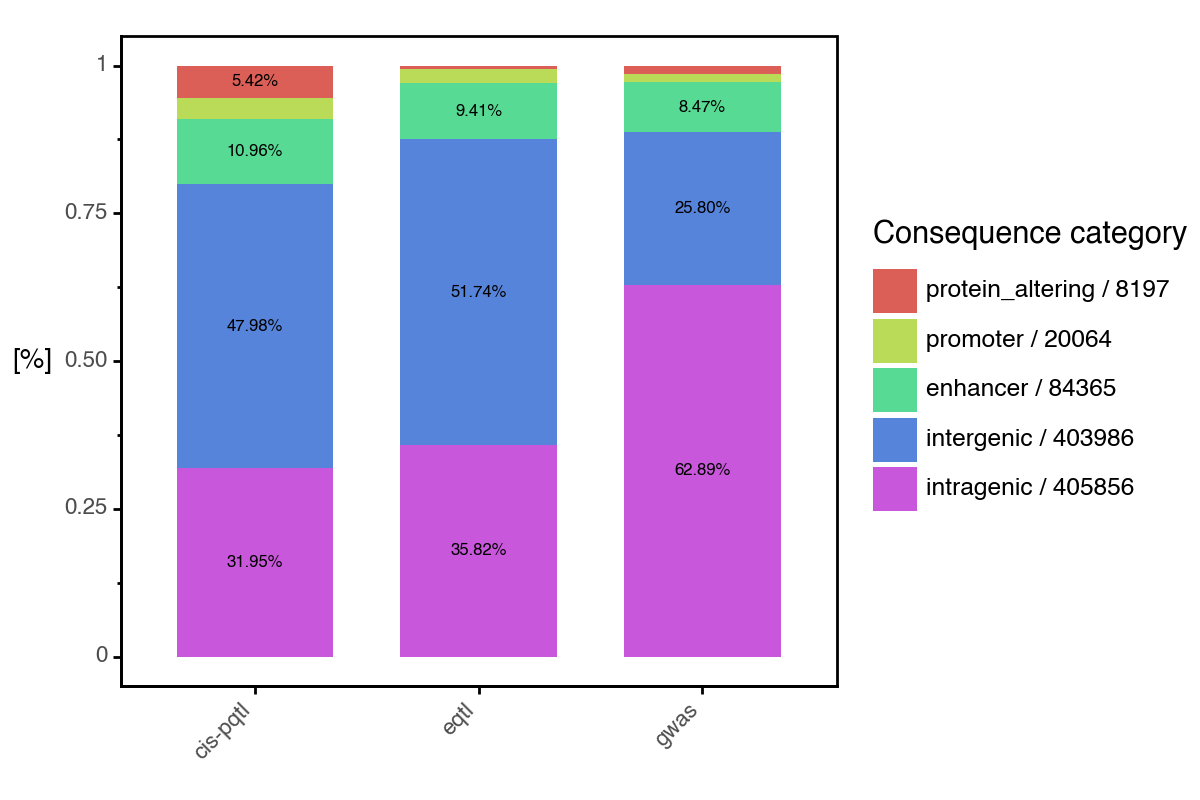

<Figure Size: (600 x 400)>

In [316]:
plot2 = (
    p9.ggplot(data2)
    + p9.geom_col(p9.aes(x="studyType", y="percentage", fill="reorder(fillLabel, totalCountPerConsequence)"), width=0.7)
    + OpenTargetsTheme.theme
    + p9.theme(figure_size=(6, 4))
    + p9.theme(axis_title_y=p9.element_text(rotation=0))
    + p9.theme(axis_text_y=p9.element_text(rotation=0, hjust=1))
    + p9.labs(x="", y="[%]", fill="Consequence category")
    + p9.theme(legend_title=p9.element_text(margin={"l": 10, "r": 10, "t": 10, "b": 10}))
    # Move the geom_text to point to the correct part of the bar
    # + p9.geom_text(p9.aes(label="%", y="percentage", x="studyType"), size=8, color="black")
    + p9.geom_text(p9.aes(label="label_to_show", y="pointLabelPosition", x="studyType"), size=6, color="black")
    # + p9.scale_fill_manual(values=[], name="Study Type")
)
plot2


## Merge plots into one figure


In [318]:
import patchworklib as pw


p1 = pw.load_ggplot(plot)
p2 = pw.load_ggplot(plot2)


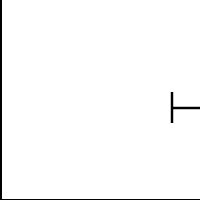

In [322]:
fig = p1 | p2
fig.savefig("plots/05.1_variant_regulatory_consequence.jpg", dpi=300, bbox_inches="tight")
